In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


(666, 500, 3)


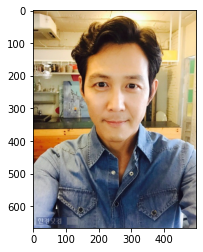

In [2]:
# 이미지 load
path_img = './img/img_1.png'
img_ori = cv2.imread(path_img)
print(img_ori.shape)

# 이미지 확인
plt.imshow(cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# PASCAL VOC label
LABEL_NAME_DEEPLABV3 = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

# 모델 로드
path_model = './model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
model = semantic_segmentation()
model.load_pascalvoc_model(path_model)
# 모델 실행 (segvalues, segment img)
# segvalues : {class_ids, masks}
# class_ids : 검출된 class index
segvalues, output = model.segmentAsPascalvoc(path_img)

In [ ]:
# output 확인
plt.imshow(output)
plt.show()

In [ ]:
print(segvalues.keys())
# 검출된 class 확인
print(segvalues['class_ids'])
for class_id in segvalues['class_ids']:
    print(LABEL_NAME_DEEPLABV3[class_id])

In [ ]:
# 색상 테이블
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# idx person = 15
print(colormap[15])
colormap_person = colormap[15]
# output : BGR 채널 배치
# colormap : RGB 채널 배치
seg_color = np.flip(colormap_person)

# seg_color로 masking
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [ ]:
buf_img = img_ori.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# mask의 색상 스타일 변경 (사용자 정의 colormap 사용, cv2.COLORMAP_JET)
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_OCEAN)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
print(type(color_mask))

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
buf_img = cv2.addWeighted(buf_img, 0.6, color_mask, 0.4, 0.0)
# img_show = cv2.addWeighted(buf_img, 0.6, img_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(buf_img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# blur 처리
# cv2.blur(img, blurring kernel size)
# blurring kernel size = (x, y)
img_blur = cv2.blur(img_ori, (10, 30))  
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 배경 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 반전 (person : 0, back : 255)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# (person : 255, back : 0)
img_concat = np.where(img_mask_color==255, img_ori, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()